In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spy
from tqdm import tqdm
import time
import pickle
import glob
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.multitest import fdrcorrection

InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',None)

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [82]:
L2S={'Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease':
     'Hypertensive chronic kidney disease',
     'Personal history of other venous thrombosis and embolism':
     'Personal history of other venous thrombosis',
     'Presence of coronary angioplasty implant and graft':
     'Presence of coronary angioplasty implant',
     'Atherosclerotic heart disease of native coronary artery without angina pectoris':'Atherosclerotic disease',
     'Long term (current) use of antithrombotics/antiplatelets':
     'Long term (current) use of antithrombotics',
     'Hypertrophy (benign) of prostate without urinary obstruction and other lower urinary tract symptom (LUTS)':
     'Hypertrophy of prostate w/o urinary obstruction',
     'Type 2 diabetes mellitus with diabetic peripheral angiopathy without gangrene':
     'Type 2 diabetes with diabetic peripheral angiopathy',
     'Adverse effect of antineoplastic and immunosuppressive drugs': 'Adverse effect of antineoplastic drugs',
     'Personal history of venous thrombosis and embolism':'History of venous thrombosis',
     'Coronary atherosclerosis of native coronary artery':'Coronary atherosclerosis of artery',
     'Coronary atherosclerosis of unspecified type of vessel':'Coronary atherosclerosis of vessel',
     'Chronic hepatitis C without mention of hepatic coma': 'Chronic hepatitis C w/o hepatic coma',
     'Percutaneous transluminal coronary angioplasty status': 'Percutaneous coronary angioplasty',
     'Unspecified dementia without behavioral disturbance':'Dementia w/o behavioral disturbance',
     'Non-ST elevation (NSTEMI) myocardial infarction': 'NSTEMI myocardial infarction',
     'Personal history of transient ischemic attack (TIA)': 'History of ischemic attack',
     'Benign prostatic hyperplasia without lower urinary tract symptoms': 'Benign prostatic hyperplasia',
     'Diabetes mellitus due to underlying condition with diabetic polyneuropathy': 'Diabetes mellitus with neuropathy',
     'Age-related osteoporosis without current pathological fracture': 'osteoporosis w/o pathological fracture'}

def shorten_icd_name(n1):
    n2=n1.split(',')[0]
    
    if n2 in L2S.keys():
        n3=L2S[n2]
    else:
        n3=n2
    return n3.replace('without','w/o')

# identify predictive factor by chi-square and plot the results with heatmap

In [79]:
icd9_to_10=pd.read_table("tables/icd9_to_icd10_conversion.txt", sep='\t', index_col=0)
icd9_to_10['icd10']=icd9_to_10['icd10'].map(lambda x: x.replace('.',''))
icd9_to_10.loc['4241']='I350'
icd9_to_10.loc['2724']='E785'
icd9_to_10

,icd10
icd9,
42731,I4891
V4581,Z951
41401,I2510
4241,I350
41400,I2510
412,I252
V4582,Z9861
V5861,Z7901
3572,"E0842,E0942,E1042,E1142,E1342"


In [80]:
multiple_mapped_ICD10=[
    'I350','I351','I352','I358','I359',
    'E0842','E0942','E1042','E1142','E1342',
    'E784','E785',
    'M1990','M159',
    'E7800','E7801']

sig_ICD10=['age', 'Z7901', 'I4891', 'I2510', 'I739', 'J449', 'Z794', 'I350',
       'Z87891', 'E875', 'I480', 'I252', 'I214', 'Z7902', 'Z951', 'Z8673',
       'E669', 'J189', 'F329', 'E1165', 'E785', 'E039', 'N179', 'Z955',
       'F17210', 'J45909', 'N400', 'M109']

set(multiple_mapped_ICD10)&set(sig_ICD10)

{'E785', 'I350'}

,AL,G1,G2,G3,max
age,115.050848,10.258017,9.429464,2.859823,115.050848
42731,75.587097,20.781802,11.225282,11.786817,75.587097
V4581,39.669393,9.639947,9.596420,7.218954,39.669393
41401,37.355491,16.016616,9.030255,5.695851,37.355491
4241,25.945830,NaN,3.059993,6.465751,25.945830
412,20.301734,5.742194,7.375664,3.266866,20.301734
V4582,20.173576,3.845650,5.735595,6.234384,20.173576
V5861,13.772322,4.977054,4.788472,NaN,13.772322
3572,NaN,13.738137,3.748415,NaN,13.738137
5849,11.130750,2.577134,4.809862,NaN,11.130750


,AL,G1,G2,G3,max
age,26.567405,7.512523,NaN,NaN,26.567405
Z7901,23.789919,5.638753,6.694343,5.720831,23.789919
I4891,19.328913,4.099995,6.280479,2.588740,19.328913
I2510,17.833736,2.775905,10.440101,NaN,17.833736
I739,16.727426,NaN,8.674743,3.193942,16.727426
J449,13.204758,6.900358,5.998061,NaN,13.204758
Z794,9.818960,3.803212,6.887878,2.632500,9.818960
I350,9.236602,NaN,NaN,3.004764,9.236602
Z87891,8.520829,NaN,4.547937,NaN,8.520829
E875,6.415643,5.228230,3.398244,NaN,6.415643


,AL,G1,G2,G3,max,AL,G1,G2,G3
AGE [age],115.050848,10.258017,9.429464,2.859823,115.050848,26.567405,7.512523,NaN,NaN
Unspecified atrial fibrillation [I4891],75.587097,20.781802,11.225282,11.786817,75.587097,19.328913,4.099995,6.280479,2.588740
Presence of aortocoronary bypass graft [Z951],39.669393,9.639947,9.596420,7.218954,39.669393,5.327039,NaN,3.735208,NaN
Atherosclerotic disease [I2510],37.355491,16.016616,9.030255,5.695851,37.355491,17.833736,2.775905,10.440101,NaN
Nonrheumatic aortic (valve) stenosis [I350],25.945830,NaN,3.059993,6.465751,25.945830,9.236602,NaN,NaN,3.004764
Old myocardial infarction [I252],20.301734,5.742194,7.375664,3.266866,20.301734,5.835495,NaN,6.181097,NaN
Coronary angioplasty status [Z9861],20.173576,3.845650,5.735595,6.234384,20.173576,NaN,NaN,NaN,NaN
Long term (current) use of anticoagulants [Z7901],13.772322,4.977054,4.788472,NaN,13.772322,23.789919,5.638753,6.694343,5.720831
Diabetes mellitus with neuropathy [E0842],NaN,13.738137,3.748415,NaN,13.738137,NaN,NaN,NaN,NaN
Acute kidney failure [N179],11.130750,2.577134,4.809862,NaN,11.130750,2.813720,2.234264,2.263302,NaN


(45, 9)

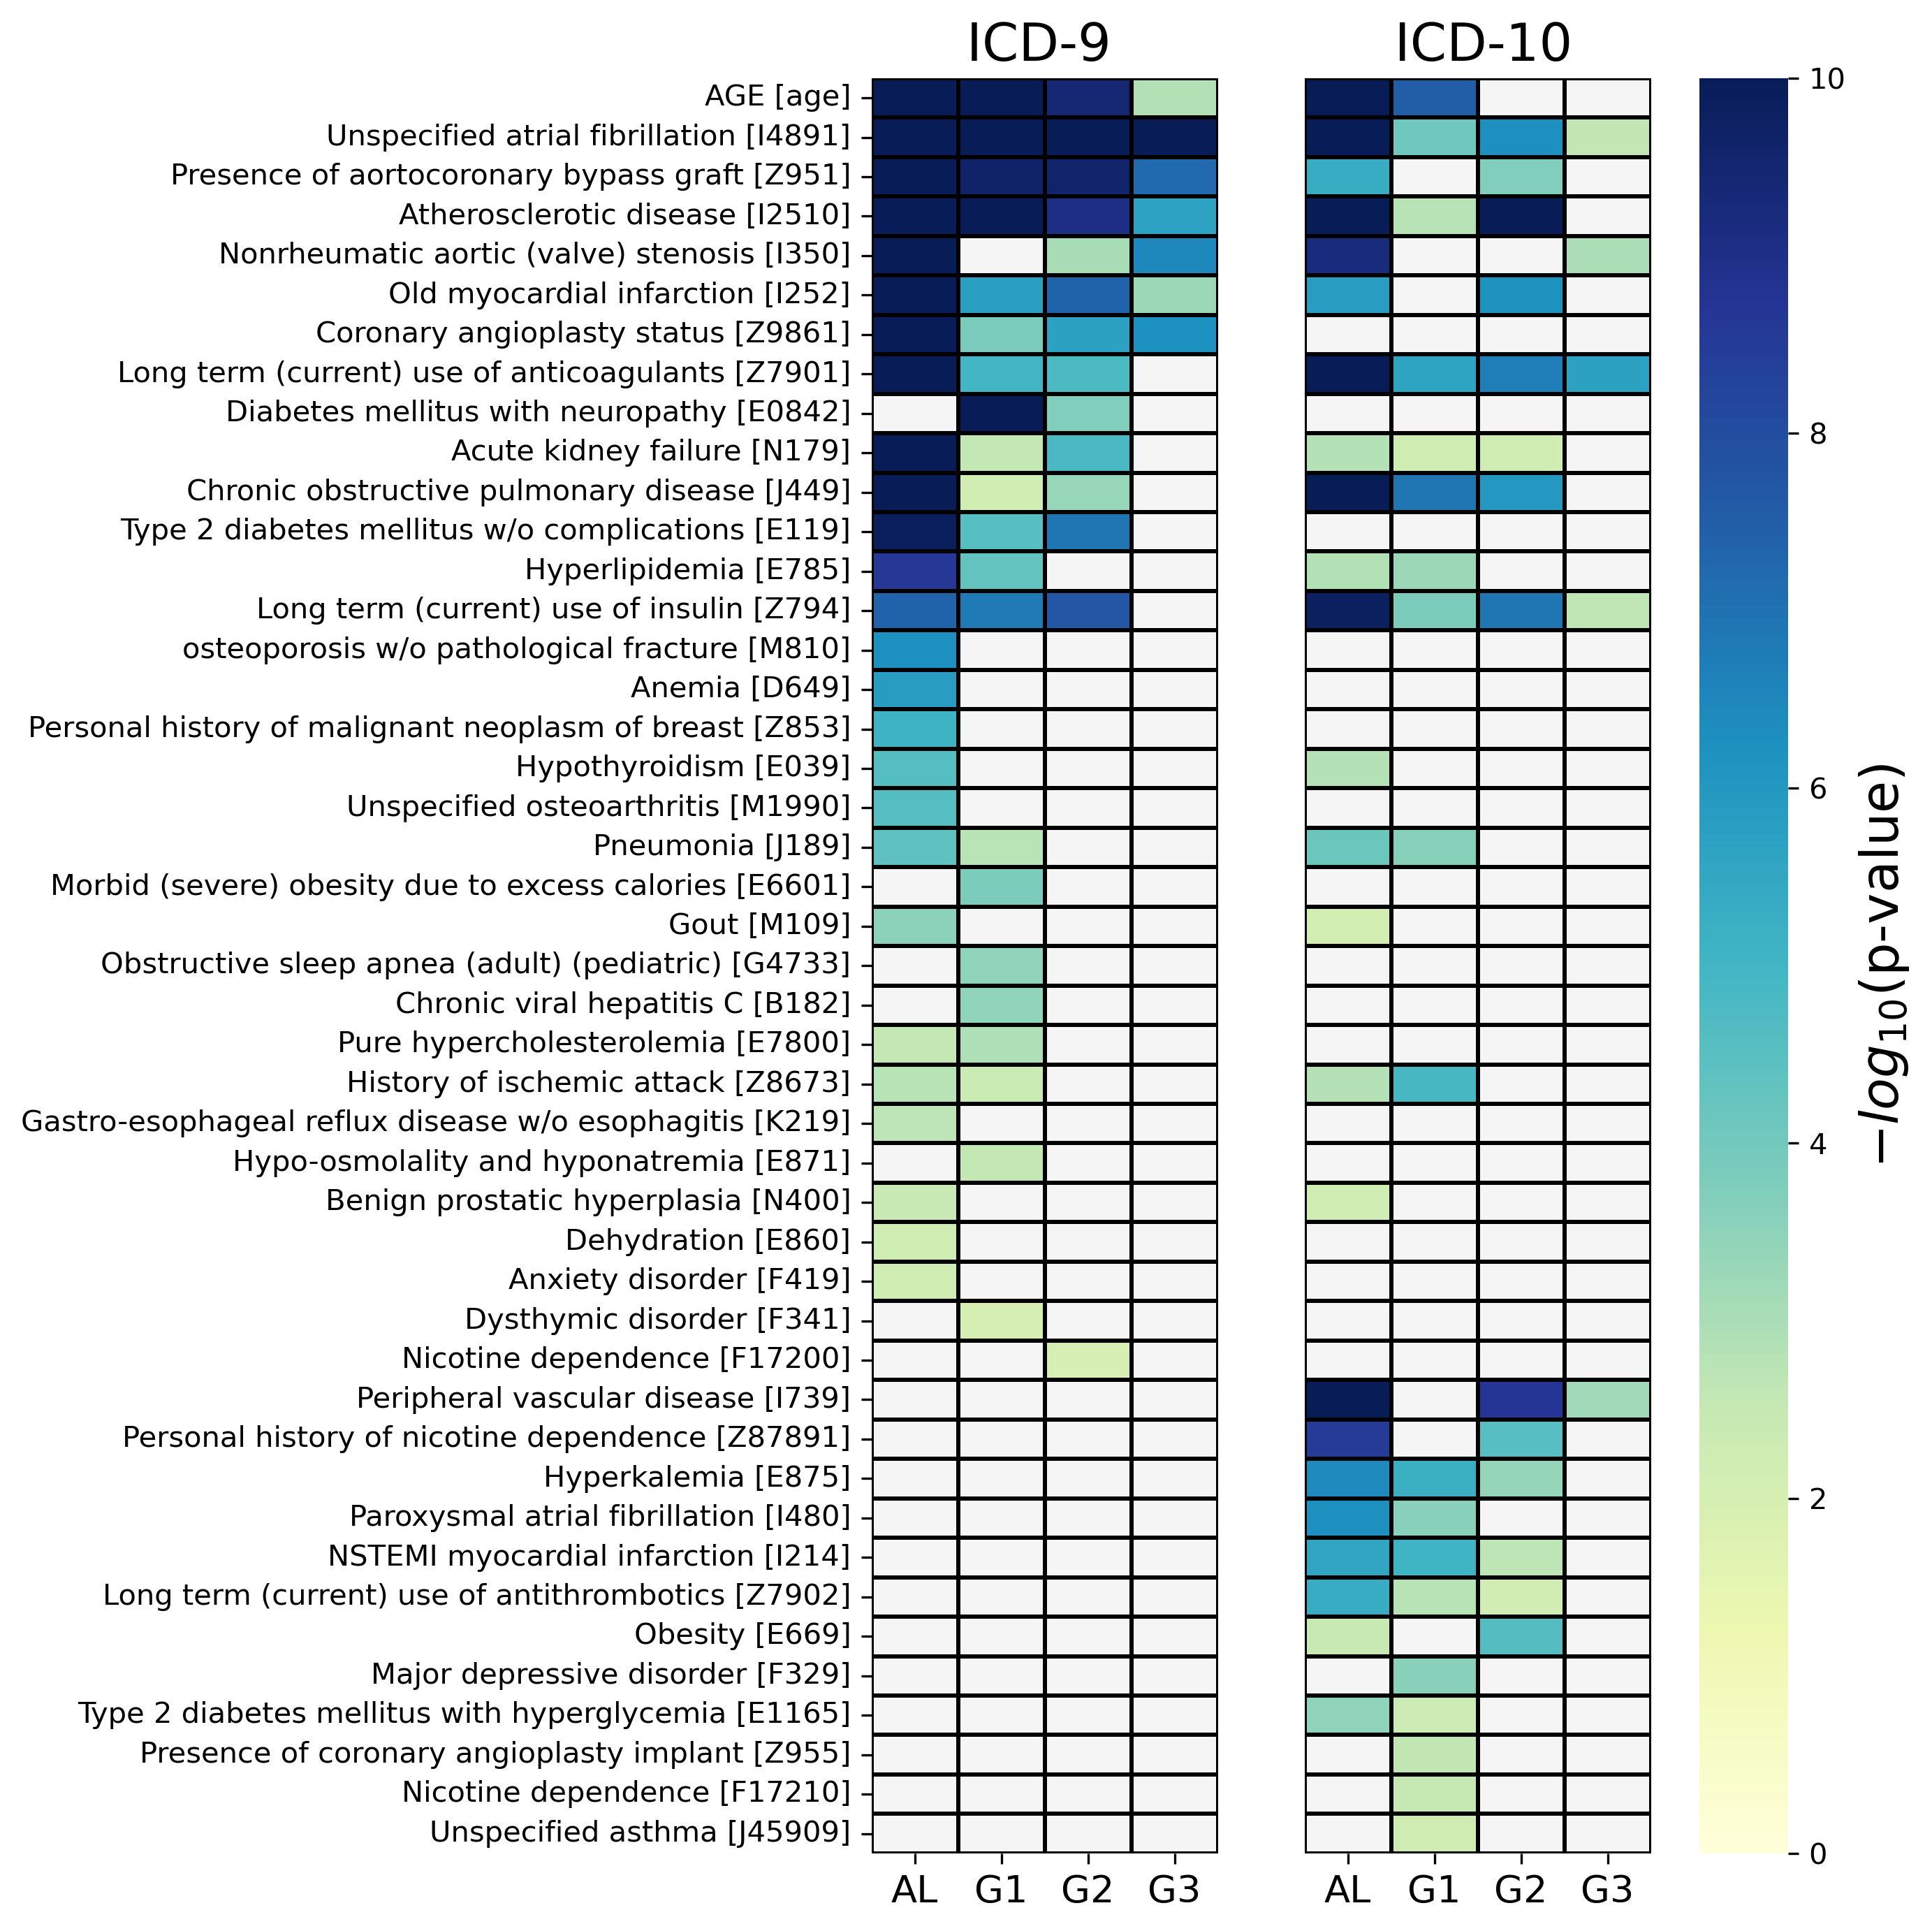

In [145]:
from matplotlib.patches import Rectangle

fig=plt.figure(figsize=(6,11), dpi=300)

ax1=fig.subplots()

chi2_res_sig_both=pd.DataFrame()
for ICD_VER in [9,10]:
    d_icd=pd.read_table("/data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv", sep=',', index_col=0)
    d_icd.index=d_icd.index.str.strip()
    d_icd.loc['gender']=[ICD_VER, 'GENDER']
    d_icd.loc['age']=[ICD_VER, 'AGE']
    
    d_icd10=d_icd.loc[d_icd['icd_version']==10]
    
    chi2_res_df=pd.DataFrame()
    for file_path in glob.glob("./results/data_cl1_icd{}_*_*.pickle".format(ICD_VER)):
        Hage_th1, Hage_th2 = file_path.split('.')[-2].split('_')[-2:]

        with open(file_path, 'rb') as f:
            cl1_dat=pickle.load(f)
            cl1_age_vals=cl1_dat['H_age']
            cl1_dat=cl1_dat.drop(columns=['subject_id','H_time','H_age'])
            cl1_dat['gender']=cl1_dat['gender'].replace({'M':1, 'F':0})

        with open(file_path.replace('data_cl1_icd','data_cl0_icd'), 'rb') as f:
            cl0_dat=pickle.load(f)
            cl0_age_vals=cl0_dat['H_age']
            cl0_dat=cl0_dat.drop(columns=['subject_id','H_time','H_age'])
            cl0_dat['gender']=cl0_dat['gender'].replace({'M':1, 'F':0})

        cl1_sr=cl1_dat.iloc[:,:-1].applymap(lambda x: x>0).sum(axis=0).sort_values(ascending=True)
        cl0_sr=cl0_dat.iloc[:,:-1].applymap(lambda x: x>0).sum(axis=0).sort_values(ascending=True)

        mer_df=pd.concat([cl0_sr,cl1_sr], axis=1)
        mer_df.columns=['H0','HF']

        mer_df['H0_norm']=mer_df['H0']/len(cl0_dat)
        mer_df['HF_norm']=mer_df['HF']/len(cl1_dat)
        mer_df=mer_df.loc[(mer_df['H0']!=0)|(mer_df['HF']!=0)]

        def chi2_test(sr1):
            pat_num_sr=pd.Series(pat_cl01_num, index=['H0','HF'])
            df1=pd.concat([sr1,pat_num_sr-sr1], axis=1)
            df1.columns=[sr1.name+'_O', sr1.name+'_X']
            res = chi2_contingency(df1)
            tval=res[0]
            pval=res[1]

            if pval<0.01:
                if tval>0:
                    return -np.log10(pval)
                else:
                    return np.log10(pval)
            else:
                return np.nan

        pat_cl01_num=[len(cl0_dat), len(cl1_dat)]
        chi2_res=mer_df[['H0','HF']].apply(chi2_test, axis=1)

        def mannwhitneyu_test(cl1_age_vals, cl0_age_vals):
            res=mannwhitneyu(cl1_age_vals, cl0_age_vals)
            pval=res[1]

            if pval<0.01:
                return -np.log10(pval)
            else:
                return np.nan

        chi2_res.loc['age']=mannwhitneyu_test(cl1_age_vals, cl0_age_vals)

        chi2_res.name='[{}-{})'.format(Hage_th1, Hage_th2)
        chi2_res_df=pd.concat([chi2_res_df,chi2_res], axis=1)
        
        
    chi2_res_df=chi2_res_df.rename(columns={'[0-120)': 'AL', '[0-65)': 'G1', '[65-80)': 'G2', '[80-120)': 'G3'})
    chi2_res_df=chi2_res_df[['AL','G1','G2','G3']]
    chi2_res_df['max']=chi2_res_df.max(axis=1)
    chi2_res_df.sort_values(by='max', ascending=False, inplace=True)
    chi2_res_sig=chi2_res_df.loc[chi2_res_df['max'].notnull()]
    
    chi2_res_sig=chi2_res_sig.copy()
    chi2_res_sig.drop(index=['41400','25060'], errors='ignore', inplace=True)

    ##### for save file
    chi2_res_supple_mat_save=chi2_res_sig.copy()
    chi2_res_supple_mat_save.reset_index(inplace=True)
    chi2_res_supple_mat_save.rename(columns={'index':'ICD-{}'.format(ICD_VER)}, inplace=True)

    if ICD_VER==9:
        chi2_res_supple_mat_save['ICD-10']=chi2_res_supple_mat_save['ICD-9'].replace(icd9_to_10['icd10'])
        chi2_res_supple_mat_save['ICD-10']=chi2_res_supple_mat_save['ICD-10'].map(lambda x: x.split(',')[0])
        
    chi2_res_supple_mat_save['long_title (ICD-10)']=chi2_res_supple_mat_save['ICD-10'].replace(d_icd10['long_title'])
    chi2_res_supple_mat_save.to_csv('tables/chi2_res_icd{}_rev.txt'.format(ICD_VER), sep='\t')
     ##### for save file
        
    chi2_res_sig.rename(index=icd9_to_10['icd10'], inplace=True)# <==== comma 제거, manually mapping 사전 파일 다시 생성 저장
    chi2_res_sig_both=pd.concat((chi2_res_sig_both, chi2_res_sig), axis=1)

###########
chi2_res_sig_both.index=chi2_res_sig_both.index.map(lambda x: x.split(',')[0])

chi2_res_sig_both.index=chi2_res_sig_both.index.map(lambda x: '{} [{}]'.format(shorten_icd_name(d_icd10.loc[x,'long_title']), x))
chi2_res_sig_both=chi2_res_sig_both.iloc[:,:-1]

mask = np.zeros((45, 9))
mask[:,4] = True
_=sns.heatmap(chi2_res_sig_both, mask=mask, ax=ax1, cmap='YlGnBu', linecolor='k', linewidths=1, vmin=0, vmax=10)
_=ax1.set_facecolor('whitesmoke')

_=ax1.add_patch(Rectangle((4, 0), 1, 45, ec='none', fc='w', lw=1))
_=ax1.set_xticks(np.array([0,1,2,3,5,6,7,8])+0.5, labels=['AL','G1','G2','G3']*2)

_=ax1.tick_params(axis='x', labelrotation=0, labelsize=13)

_=ax1.set_title(' ICD-9                 ICD-10', fontsize=18)
_=ax1.collections[0].colorbar.set_label("$-log_{10}$(p-value)", fontsize=18)

fig.savefig('figures/chi2_res_one_axes_rev.jpg', bbox_inches='tight', dpi=300)